In [2]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import plt_utils

with open("../outputs/prefix_proportion.json", "r") as f:
    prefix_proportion = json.load(f)
with open("result_paths_ttft_qwen.json", 'r') as f:
    result_qwen = {int(k): v for k, v in json.load(f).items()}
with open("result_paths_ttft_opt.json", 'r') as f:
    result_opt = {int(k): v for k, v in json.load(f).items()}

def augment_result(result):
    for group in result:
        result[group]['LocalRetrieval'] = result_qwen[0]['LocalRetrieval']
        result[group]['RemoteRetrieval'] = result_qwen[group]['RemoteRetrieval']
    
def calc_result(result):
    for group in result:
        if result[group]['RemoteRetrieval'] == 0 or result[group]['DownloadKV'] == "":
            result[group]['DRAGON'] = 0
            result[group]['DRCG/Text'] = 0
            result[group]['DRCG/KV'] = 0
            result[group]['CRCG/Device'] = 0
            result[group]['CRCG/Cloud'] = 0
            del result[group]['stats_device']
            del result[group]['stats_cloud']
            del result[group]['LocalRetrieval']
            del result[group]['RemoteRetrieval']
            del result[group]['DownloadKV']
            continue
        with open(Path("..") / result[group]['stats_device']) as f:
            stats_device = json.load(f)
        with open(Path("..") / result[group]['stats_cloud']) as f:
            stats_cloud = json.load(f)
        with open(Path("..") / result[group]['DownloadKV']) as f:
            stats_kv = json.load(f)
        prefilling_device = np.array([stats['Prefilling'] for stats in stats_device])
        prefilling_prefix_device = np.array([
            stat_device['Prefilling'][0] * stat_prop["PrefixProportion"][0]
            for stat_device, stat_prop in zip(stats_device, prefix_proportion)])
        prefilling_postfix_device = np.array([
            stat_device['Prefilling'][0] * (1 - stat_prop["PrefixProportion"][0])
            for stat_device, stat_prop in zip(stats_device, prefix_proportion)])
        prefilling_postfix_cloud = np.array([
            stat_cloud['Prefilling'][0] * (1 - stat_prop["PrefixProportion"][0])
            for stat_cloud, stat_prop in zip(stats_cloud, prefix_proportion)])
        
        ttft = np.array([stats['TTFT'] for stats in stats_device])
        download_kv = np.array([stats['DownloadKV'] for stats in stats_kv])[1:]
        # Dragon、DRDG/TW、DRDG/SW: cloud-side retrieval + download token
        # DRCG/Text: cloud-side retrieval + download text + prefilling
        # DRCG/KV: cloud-side retrieval + download KV
        # CRCG/Device: cloud-side retrieval
        # CRCG/Cloud: cloud-side retrieval
        result[group]['DRAGON'] = ttft - prefilling_prefix_device
        result[group]['DRCG/Text'] = result[group]['RemoteRetrieval'] + prefilling_device
        result[group]['DRCG/KV'] = result[group]['LocalRetrieval'] + download_kv + prefilling_postfix_device
        result[group]['CRCG/Device'] = result[group]['LocalRetrieval'] + prefilling_postfix_device
        result[group]['CRCG/Cloud'] = result[group]['LocalRetrieval'] + prefilling_postfix_cloud

        del result[group]['stats_device']
        del result[group]['stats_cloud']
        del result[group]['LocalRetrieval']
        del result[group]['RemoteRetrieval']
        del result[group]['DownloadKV']
    # print(json.dumps(result, indent=4))

augment_result(result_opt)
augment_result(result_qwen)
calc_result(result_qwen)
calc_result(result_opt)

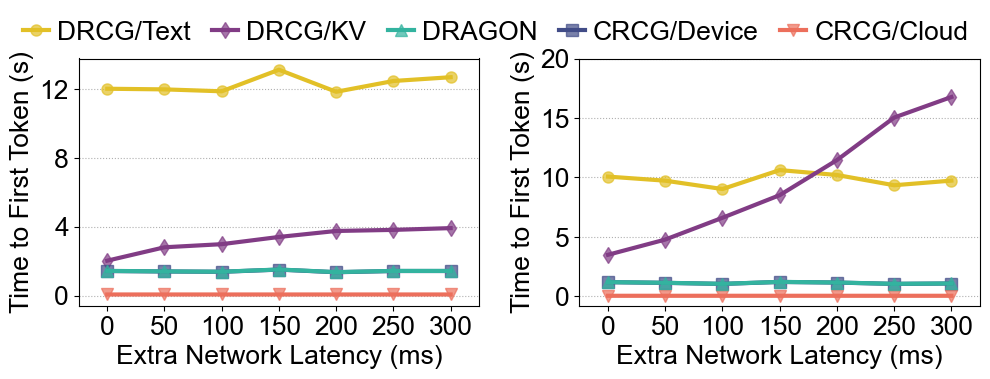

In [3]:
def hex2rgb(hex_color: str):
    hex_color = hex_color.lstrip('#')
    rgb_color = list(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    return rgb_color

methods = ["DRCG/Text", "DRCG/KV", "DRAGON", "CRCG/Device", "CRCG/Cloud"]
colors = ['#e2c027', '#813c85', '#33B39F', '#414C87', '#EC6F5C']
marker = ['o', 'd', '^', 's', 'v']

font = plt_utils.Font("arial", size=19)
n_docs_list = list(range(2, 17, 2))
marker_alpha = 0.7
yticks = [
    np.arange(0, 14, 4),
    np.arange(0, 25, 5),
]
plt.figure(figsize=(10, 3.5), dpi=100)
for i, result in enumerate([result_qwen, result_opt]):
    plt.subplot(1, 2, i + 1)
    for j, method in enumerate(methods):
        stats = np.array([result[group][method] for group in result]).reshape(len(result), -1)
        plt.plot(
            np.mean(stats, axis=1), label=method, zorder=3 if method == "DRAGON" else 2, markersize=8, linewidth=3,
            marker=marker[j % len(marker)], color=colors[j % len(colors)],
            markerfacecolor=hex2rgb(colors[j % len(colors)]) + [marker_alpha]
        )
        # plt.errorbar(np.arange(len(stats)), np.mean(stats, axis=1), yerr=np.std(stats, axis=1) / np.sqrt(len(stats)), fmt='none', color=colors[j % len(colors)], capsize=5)
    plt.xticks(np.arange(len(result)), [0, 50, 100, 150, 200, 250, 300], fontproperties=font)
    plt.xlim(-0.5, len(result) - 0.5)
    plt.yticks(yticks[i], fontproperties=font)
    plt.xlabel('Extra Network Latency (ms)', fontproperties=font)
    plt.ylabel('Time to First Token (s)', fontproperties=font)
    plt.grid(axis='y', linestyle=':', zorder=1)
    plt.tight_layout()
plt.legend(
    prop=font, loc='upper right', bbox_to_anchor=(1.03, 1.25),
    ncol=5, labelspacing=0.2, columnspacing=0.8, 
    frameon=False, handlelength=1, handletextpad=0.3
)
plt.subplots_adjust(wspace=0.25)
plt.savefig("figures/ttft.pdf", bbox_inches='tight')
plt.show()

In [4]:
print(np.mean([lat["DRCG/Text"] for lat in result_qwen.values()]) / np.mean([lat["DRAGON"] for lat in result_qwen.values()]))
print(np.mean([lat["DRCG/Text"] for lat in result_opt.values()]) / np.mean([lat["DRAGON"] for lat in result_opt.values()]))

8.595909237377274
8.605617181795674


In [6]:
print(np.mean(result_qwen[300]['DRCG/KV']) / np.mean(result_qwen[300]['DRAGON']))
print(np.mean(result_opt[300]['DRCG/KV']) / np.mean(result_opt[300]['DRAGON']))
print(np.mean(result_qwen[300]['DRCG/Text']) / np.mean(result_qwen[300]['DRAGON']))
print(np.mean(result_opt[300]['DRCG/Text']) / np.mean(result_opt[300]['DRAGON']))

2.7310125332282853
15.285238549903461
8.830644586031559
8.87902606902761
